<a href="https://colab.research.google.com/github/RoyAru11/Finance-/blob/main/Market_Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


In [2]:
def compute_capm_plot_sml_with_test(risky_assets, training_start_date, training_end_date, risk_free_rate):
    """
    Compute CAPM beta from a training period and plots actual returns from a testing period
    against the SML
    """
    market_ticker = '^NSEI' # NIFTY 50
    testing_start_date = pd.to_datetime(training_end_date) + pd.Timedelta(days=1)
    testing_end_date = testing_start_date + pd.DateOffset(years=1) - pd.Timedelta(days=1)

    print("Fetching training data...")
    try:
        training_data = yf.download(
            risky_assets + [market_ticker],
            start=training_start_date,
            end=training_end_date, progress=False)['Close']
    except Exception as e:
        print(f"Error fetching training data: {e}")
        return None

    # Calculate returns for the training period
    training_returns = training_data.pct_change().dropna()
    market_training_returns = training_returns[market_ticker]
    daily_risk_free_rate = (1 + risk_free_rate) ** (1/252) - 1
    market_risk_premium = market_training_returns.mean() - daily_risk_free_rate

    # Calculate beta for each stock using the training period data
    betas = {}
    for stock in risky_assets:
        try:
            asset_training_returns = training_returns[stock]
            beta, _, _, _, _ = stats.linregress(market_training_returns, asset_training_returns)
            betas[stock] = beta
        except KeyError:
            print(f"Skipping {stock} in training: No data available.")
        except Exception as e:
            print(f"Error calculating beta for {stock}: {e}")

    # Fetch testing data
    print("\n----------Fetching Testing Data-------------")
    try:
        testing_data = yf.download(
            risky_assets,
            start=testing_start_date.strftime('%Y-%m-%d'),
            end=testing_end_date.strftime('%Y-%m-%d'), progress=False)['Close']
    except Exception as e:
        print(f"Error fetching testing data: {e}")
        return None

    # Calculate annualized actual returns for the testing period
    actual_returns = {}
    for stock in risky_assets:
        try:
            initial_price = testing_data[stock].iloc[0]
            final_price = testing_data[stock].iloc[-1]
            raw_return = final_price / initial_price - 1
            days_in_period = (testing_end_date - testing_start_date).days
            annualized_return = (1 + raw_return) ** (365/days_in_period) - 1
            actual_returns[stock] = annualized_return
        except KeyError:
            print(f"Skipping {stock} in testing: No data available.")

    # Create a DataFrame for the table
    results_df = pd.DataFrame({
        'Beta (from training)': pd.Series(betas),
        'Actual Annualized (from Testing)': pd.Series(actual_returns)
    })

    #------ Plotting the Security Market line (SML)
    print("\nPlotting the Security Market Line")
    sml_betas = np.linspace(min(betas.values()) - 0.1, max(betas.values()) + 0.1, 100)
    sml_expected_returns = (1 + daily_risk_free_rate + sml_betas * market_risk_premium) ** 252 - 1

    plt.figure(figsize=(12,8))
    plt.plot(sml_betas, sml_expected_returns, label='Security Market Line', linestyle='--', color='r')

    # Plot the individual stocks with their actual returns
    plt.scatter(results_df['Beta (from training)'], results_df['Actual Annualized (from Testing)'],
                label='Stocks (Actual Returns)', color='b', alpha=0.7)

    for i, row in results_df.iterrows():
        plt.text(row['Beta (from training)'] * 1.05, row['Actual Annualized (from Testing)'] * 1.05,
                 i, fontsize=9)

    plt.title(f'SML with Actual Returns ({testing_start_date.strftime("%Y-%m-%d")} to {testing_end_date.strftime("%Y-%m-%d")})')
    plt.xlabel('Beta ($β$) from Training Period')
    plt.ylabel('Actual Annualized Return from Testing Period')
    plt.axhline(y=risk_free_rate, color='g', linestyle='-', label=f'Risk-Free Rate ({risk_free_rate*100:.1f}%)')
    plt.grid(True)
    plt.legend()
    plt.show()

    return results_df


Fetching training data...


/tmp/ipython-input-2634366277.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  training_data = yf.download(



----------Fetching Testing Data-------------


/tmp/ipython-input-2634366277.py:41: FutureWarning: YF.download() has changed argument auto_adjust default to True
  testing_data = yf.download(



Plotting the Security Market Line


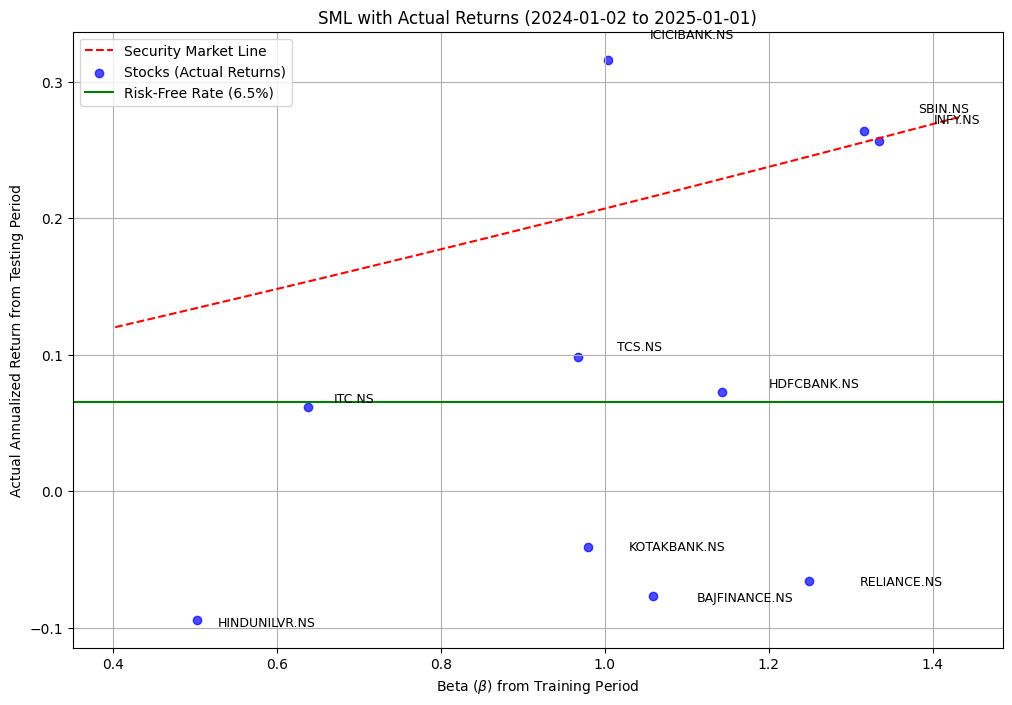


--- CAPM Results Table ---
               Beta (from training)  Actual Annualized (from Testing)
RELIANCE.NS                1.248771                         -0.066068
TCS.NS                     0.967081                          0.097961
INFY.NS                    1.334235                          0.256794
HDFCBANK.NS                1.143556                          0.072296
ICICIBANK.NS               1.004476                          0.316043
ITC.NS                     0.638055                          0.061885
HINDUNILVR.NS              0.502861                         -0.094285
SBIN.NS                    1.316124                          0.264025
KOTAKBANK.NS               0.980133                         -0.041309
BAJFINANCE.NS              1.059249                         -0.077092


In [3]:
# --- Example Usage ---
risky_assets = ['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'ITC.NS', 'HINDUNILVR.NS', 'SBIN.NS', 'KOTAKBANK.NS', 'BAJFINANCE.NS']
training_start_date = '2023-01-01'
training_end_date = '2024-01-01'
risk_free_rate = 0.065

results_table = compute_capm_plot_sml_with_test(risky_assets, training_start_date, training_end_date, risk_free_rate)
if results_table is not None:
    print("\n--- CAPM Results Table ---")
    print(results_table)

Fetching training data...


/tmp/ipython-input-2634366277.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  training_data = yf.download(



----------Fetching Testing Data-------------


/tmp/ipython-input-2634366277.py:41: FutureWarning: YF.download() has changed argument auto_adjust default to True
  testing_data = yf.download(



Plotting the Security Market Line


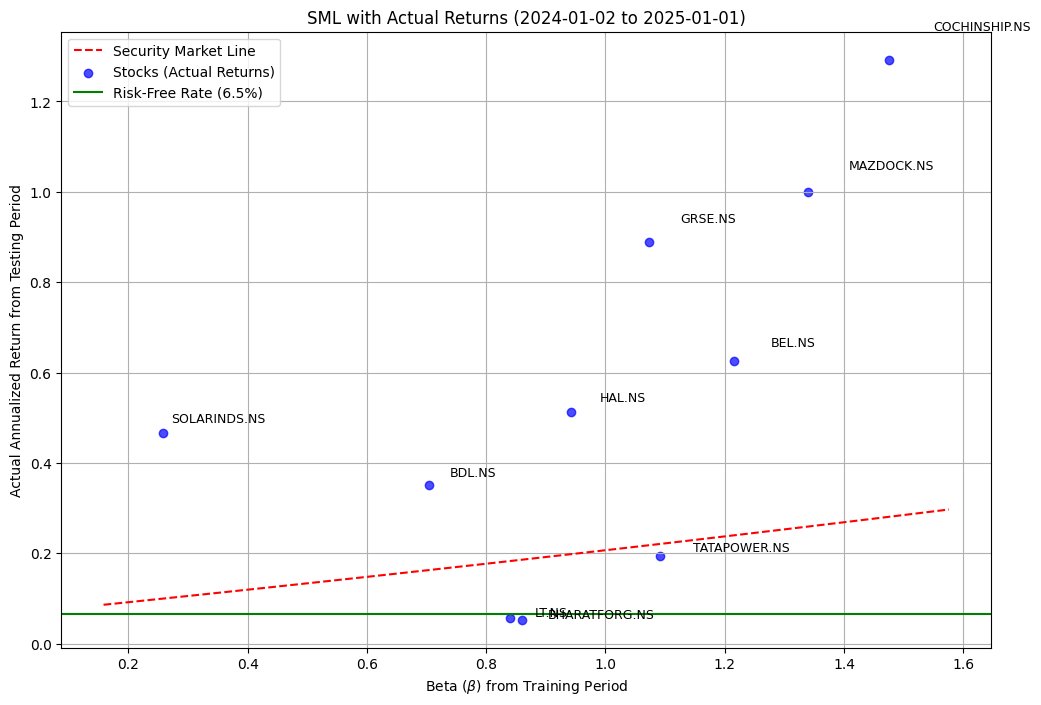


--- CAPM Results Table ---
               Beta (from training)  Actual Annualized (from Testing)
HAL.NS                     0.942887                          0.511777
BEL.NS                     1.216176                          0.625664
BDL.NS                     0.703866                          0.351664
MAZDOCK.NS                 1.340216                          1.000280
COCHINSHIP.NS              1.476174                          1.292195
GRSE.NS                    1.072508                          0.888566
LT.NS                      0.839628                          0.057563
BHARATFORG.NS              0.859696                          0.053215
TATAPOWER.NS               1.091740                          0.195141
SOLARINDS.NS               0.258390                          0.465904


In [4]:
# --- Example Usage ---
risky_assets = [
    'HAL.NS', 'BEL.NS', 'BDL.NS', 'MAZDOCK.NS', 'COCHINSHIP.NS',
    'GRSE.NS', 'LT.NS', 'BHARATFORG.NS', 'TATAPOWER.NS', 'SOLARINDS.NS'
]
training_start_date = '2023-01-01'
training_end_date = '2024-01-01'
risk_free_rate = 0.065

results_table = compute_capm_plot_sml_with_test(risky_assets, training_start_date, training_end_date, risk_free_rate)
if results_table is not None:
    print("\n--- CAPM Results Table ---")
    print(results_table)